In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from tqdm.notebook import tqdm

In [2]:
df = pd.read_csv('../../Data/OASIS/oasis_3.csv')
print(df.shape)

(2168, 22)


In [3]:
df.head()

,Subject,MR ID,id,Age,M/F,dx1,mmse,cdr,apoe,TOTAL_HIPPOCAMPUS_VOLUME,...,rhCortexVol,CortexVol,SubCortGrayVol,TotalGrayVol,SupraTentorialVol,lhCorticalWhiteMatterVol,rhCorticalWhiteMatterVol,CorticalWhiteMatterVol,L.SurfArea,R.SurfArea
0,OAS30001,OAS30001_MR_d3132,OAS30001_Freesurfer53_d3132,73.0,F,Cognitively normal,30.0,0.0,23.0,6861.9,...,178031.558882,359975.257636,48400.0,491102.257636,7.736716e+05,174372.329393,173244.012238,347616.341631,67598.1,67185.8
1,OAS30001,OAS30001_MR_d0129,OAS30001_Freesurfer53_d0129,65.0,F,Cognitively normal,30.0,0.0,23.0,7678.9,...,187528.786036,379446.180091,50687.0,517683.180091,8.105851e+05,184600.488060,182662.445419,367262.933479,70168.1,69483.8
2,OAS30001,OAS30001_MR_d2430,OAS30001_Freesurfer53_d2430,71.0,F,Cognitively normal,30.0,0.0,23.0,7105.9,...,178872.680224,357784.489639,49058.0,487405.489639,7.779313e+05,175955.968883,178172.812666,354128.781549,67905.7,68000.2
3,OAS30001,OAS30001_MR_d0757,OAS30001_Freesurfer53_d0757,67.0,F,Cognitively normal,29.0,0.0,23.0,7648.2,...,177566.874682,362040.150904,50071.0,500699.150904,7.993419e+05,185224.779932,188151.990316,373376.770247,69142.3,68558.8
4,OAS30002,OAS30002_MR_d2345,OAS30002_Freesurfer53_d2345,73.0,M,Cognitively normal,29.0,0.0,34.0,7833.2,...,230240.532783,457342.035802,56773.0,607473.035802,1.051714e+06,239168.338419,245361.377267,484529.715686,83138.1,85742.3


## Data Preprocessing

In [4]:
df = df.dropna(axis=1, how='all') # Drop any empty columns
df = df.dropna(axis=0, how='any') # Drop any rows with empty values 
df = df.rename(columns={'id':'Freesurfer ID', 'dx1':'Diagnosis', 
                        'TOTAL_HIPPOCAMPUS_VOLUME':'TotalHippocampusVol'}) # Rename columns
df = df.drop_duplicates(subset='Subject', keep='first') # Keep only the first visit; this is possible because
                                                        # df is sorted by age
df = df.reset_index(drop=True) # Reset the index
df = df.set_index('Subject')
cols = df.columns.tolist()
cols[2], cols[4] = cols[4], cols[2]
df = df[cols]
df.loc[df['cdr'] < 0.5, 'Diagnosis'] = 'control'
df.loc[~(df['cdr'] < 0.5), 'Diagnosis'] = 'dementia'
df['Diagnosis'].replace(['control','dementia'], [-1,1], inplace=True)
df['M/F'].replace(['M','F'], [0,1], inplace=True)
df = df.drop(['MR ID', 'Freesurfer ID', 'cdr'], axis=1) # Drop categorical and redundant columns

In [5]:
df.head()

,Diagnosis,M/F,Age,mmse,apoe,TotalHippocampusVol,IntraCranialVol,lhCortexVol,rhCortexVol,CortexVol,SubCortGrayVol,TotalGrayVol,SupraTentorialVol,lhCorticalWhiteMatterVol,rhCorticalWhiteMatterVol,CorticalWhiteMatterVol,L.SurfArea,R.SurfArea
Subject,,,,,,,,,,,,,,,,,,
OAS30001,-1,1,73.0,30.0,23.0,6861.9,1.186091e+06,181943.698754,178031.558882,359975.257636,48400.0,491102.257636,7.736716e+05,174372.329393,173244.012238,347616.341631,67598.1,67185.8
OAS30002,-1,0,73.0,29.0,34.0,7833.2,1.714636e+06,227101.503019,230240.532783,457342.035802,56773.0,607473.035802,1.051714e+06,239168.338419,245361.377267,484529.715686,83138.1,85742.3
OAS30003,-1,1,66.0,29.0,33.0,7983.5,1.405092e+06,204825.718573,209641.219733,414466.938306,59379.0,557900.938306,9.299305e+05,213905.159729,222232.368895,436137.528624,76695.5,78697.9
OAS30004,-1,1,61.0,30.0,23.0,8525.1,1.443177e+06,213861.671106,206884.661369,420746.332475,53910.0,566477.332475,9.709780e+05,242595.702097,233016.992108,475612.694206,87710.1,84634.9
OAS30005,-1,1,54.0,30.0,33.0,9298.2,1.554566e+06,225743.655875,224311.450543,450055.106418,63545.0,611117.106418,9.867349e+05,229534.963360,230927.823126,460462.786487,82224.0,81421.3


<AxesSubplot:xlabel='Diagnosis', ylabel='count'>

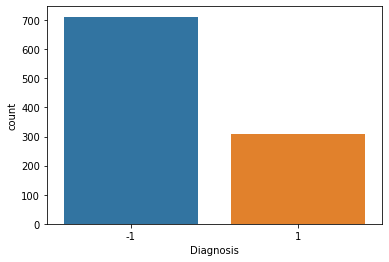

In [6]:
sns.countplot(x='Diagnosis', data=df)

In [7]:
# standard z score scaling
def scale(X):
    u = np.mean(X)
    s = np.std(X)
    X_scaled = (X-u)/s
    return X_scaled

## SVM Model

In [8]:
class SVM:
    # Larger lambda gives a wider margin and smaller lambda results in the narrow margin
    # for infinitely small λ the SVM becomes hard margin
    def __init__(self, learning_rate=0.001, lambd=0.01, iterations=1000, verbose=False):
        self.lambd = lambd
        self.learning = learning_rate
        self.iterations = iterations
        self.w = None
        self.b = None
        self.losses = []
        self.verbose = verbose

    def fit(self, X, y):
        
        self.w = np.random.normal(size=X.shape[1])
        self.b = np.random.normal()
        
        y_np = np.array(y)

        for i in (tqdm(range(self.iterations)) if self.verbose else range(self.iterations)):
            tot_loss = 0
            for idx, xi in enumerate(X):
                #print(idx, xi)
                loss = max(0, 1-(y_np[idx] * (np.dot(self.w, xi) - self.b)))
                tot_loss += loss
                if y_np[idx] * (np.dot(self.w, xi) - self.b) >= 1:
                    dw = 2 * self.lambd * self.w
                    #dw = 2 * 1/(i+1) * self.w
                    db = 0
                    self.w -= self.learning * dw.astype(float)
                    self.b -= self.learning * float(db)
                else:
                    dw = 2 * self.lambd * self.w - np.dot(y_np[idx], xi)
                    #dw = 2 * 1/(i+1) * self.w - np.dot(y_np[idx], xi)
                    db = y_np[idx]
                    self.w -= self.learning * dw.astype(float)
                    self.b -= self.learning * float(db)
            self.losses.append(tot_loss)

    def predict(self, X):
        approx = np.dot(X, self.w) - self.b
        return np.sign(approx)

## Testing SVM

In [9]:
X = df.drop(['Diagnosis'], axis=1)
y = df['Diagnosis']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(715, 17) (307, 17) (715,) (307,)


In [10]:
X_train = scale(X_train)
X_test = scale(X_test)

In [11]:
X_train.head()

,M/F,Age,mmse,apoe,TotalHippocampusVol,IntraCranialVol,lhCortexVol,rhCortexVol,CortexVol,SubCortGrayVol,TotalGrayVol,SupraTentorialVol,lhCorticalWhiteMatterVol,rhCorticalWhiteMatterVol,CorticalWhiteMatterVol,L.SurfArea,R.SurfArea
Subject,,,,,,,,,,,,,,,,,
OAS31169,0.897527,-0.743945,0.376139,0.350930,-0.230165,0.746984,0.952920,1.104031,1.033558,-0.348875,0.835688,0.715246,-0.091179,-0.026741,-0.059079,0.159115,0.186753
OAS30693,0.897527,-2.033451,0.646158,-2.142353,1.583274,-0.654318,0.541697,0.566361,0.556806,-0.192784,0.571700,0.201767,0.094366,0.101112,0.098109,0.137560,0.098679
OAS30011,0.897527,1.297771,-0.433919,0.124268,-1.282046,-0.600051,-2.250494,-2.151132,-2.211978,-0.590481,-2.176816,-1.717579,-1.521712,-1.366024,-1.448951,-1.819331,-1.779119
OAS30121,0.897527,0.008266,-0.433919,0.124268,-0.339902,-0.834229,-0.011140,0.135863,0.062576,2.826857,0.246142,0.304946,1.005270,0.972540,0.992499,0.218352,0.357672
OAS30082,0.897527,-1.066322,0.646158,0.124268,1.151894,-0.142603,1.047114,0.957621,1.007483,-0.190936,0.873790,0.613656,0.589845,0.675645,0.635208,0.497776,0.561117


In [12]:
model = SVM(verbose=True)
model.fit(np.array(X_train), y_train)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [13]:
predictions = model.predict(X_test)

In [14]:
correct_preds = np.sum(predictions == y_test)
print(f'Accuracy: {correct_preds/y_test.size}')

Accuracy: 0.8664495114006515


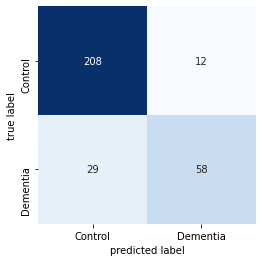

In [15]:
np_y_test = np.array(y_test).astype(int)
mat = confusion_matrix(np_y_test, predictions)
sns.heatmap(mat, square=True, annot=True, fmt='d', cbar=False, cmap='Blues',
            xticklabels=['Control', 'Dementia'],
            yticklabels=['Control', 'Dementia'])
plt.xlabel('predicted label')
plt.ylabel('true label');

In [16]:
for i in range(X_test.columns.shape[0]):
    if(model.w[i] < 0):
        print("%-27s %-3s %f" % (X_test.columns[i], ':', model.w[i]))
    else:
        print("%-27s %-3s  %f" % (X_test.columns[i], ':',  model.w[i]))
print(f'Bias value of model: {model.b}')

M/F                         :    0.012355
Age                         :   -0.164498
mmse                        :   -1.366799
apoe                        :   -0.013785
TotalHippocampusVol         :   -0.586918
IntraCranialVol             :    0.392839
lhCortexVol                 :   -0.018231
rhCortexVol                 :   -0.130610
CortexVol                   :   -0.074719
SubCortGrayVol              :    0.044978
TotalGrayVol                :    0.201353
SupraTentorialVol           :    0.063594
lhCorticalWhiteMatterVol    :    0.080537
rhCorticalWhiteMatterVol    :   -0.243602
CorticalWhiteMatterVol      :   -0.082329
L.SurfArea                  :    0.008765
R.SurfArea                  :   -0.046540
Bias value of model: 0.6087660143478597
